 ### Description
 
 This project utilized several supervised learning models to identify 
 customers who are likely to cancel services in the near future.
 Also, it extracted and analyzed top factors that contribute the most
 to user retention which could help companies to prevent from losing customers.
 
 The model formulated in this project would be suitable for predicting whether 
 a customer would or would not drop their subscriptions.

### Part 1 - Data Exploration 

#### 1.1 Load & understand the dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install seaborn --upgrade
!pip install xgboost
import pandas as pd
import numpy as np
import imblearn
import warnings
warnings.filterwarnings('ignore')

# to show all the columns
pd.set_option('display.max_columns', None)

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/churn.all')
data.head()

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [3]:
# shape of the dataset
print('number of rows: {} and columns: {}'.format(data.shape[0], data.shape[1]))

number of rows: 5000 and columns: 21


#### 1.2 Data cleaning

In [4]:
# remove unnecessary whitespaces among features that we are about to use
print('before:' + str(data['voice_mail_plan'][0]))
print('before:' + str(data['intl_plan'][0]))
print('before:' + str(data['churned'][0]))

before: yes
before: no
before: False.


In [5]:
# print(data['voice_mail_plan'])

In [6]:
# remove heading and trailing whitespaces
data['voice_mail_plan'] = data['voice_mail_plan'].map(lambda x : x.strip())
data['intl_plan'] = data['intl_plan'].map(lambda x : x.strip())
data['churned'] = data['churned'].map(lambda x : x.strip())

In [7]:
print('after:' + str(data['voice_mail_plan'][0]))
print('after:' + str(data['intl_plan'][0]))
print('after:' + str(data['churned'][0]))

after:yes
after:no
after:False.


#### 1.3 Explore features

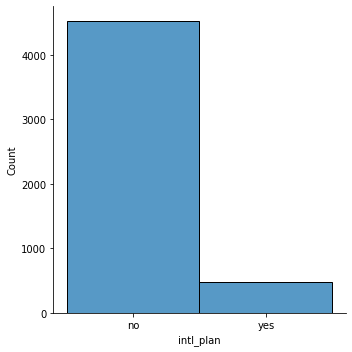

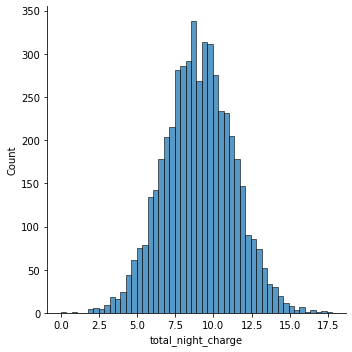

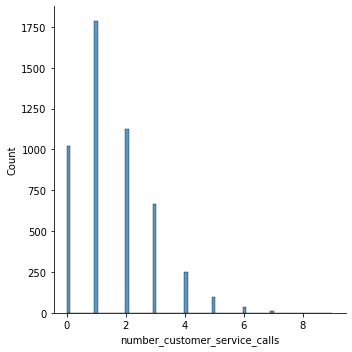

In [8]:
# plot feature values to show distribution
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(data['intl_plan'])
sns.displot(data['total_night_charge'])
sns.displot(data['number_customer_service_calls'])

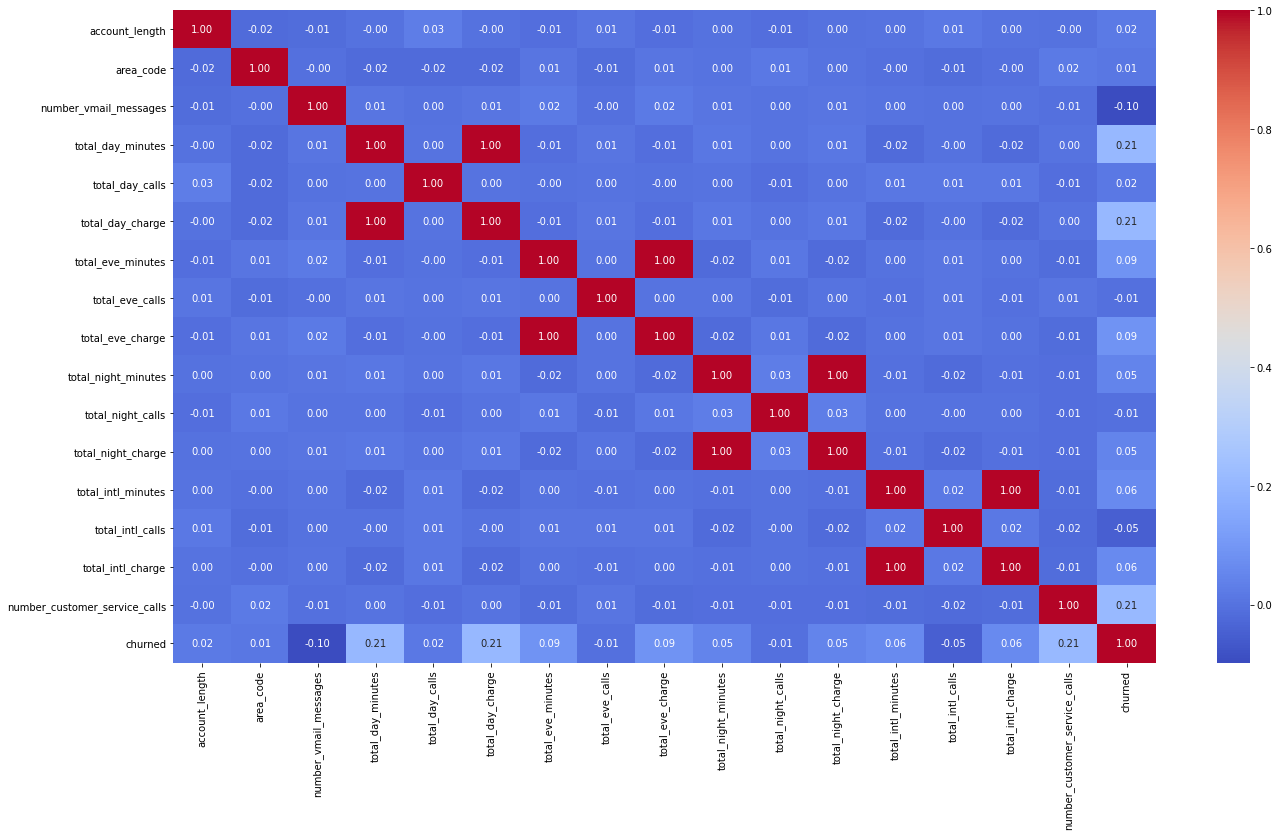

In [9]:
# calculate the Pearson correlations between all continuous features
data['churned'] = data['churned'].map({'False.' : 0, 'True.': 1})
pcorr = data.corr()
#print(pcorr)
fig, ax = plt.subplots(figsize=(22,12))
sns.heatmap(pcorr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

After examining the heatmap, we can conclude that features that have a linear correlation with churned customers are **'total_day_minutes'**, **'total_day_charge'** and **'number_customer_service_calls'**

### Part 2 - Feature Preprocessing and Selection

In [10]:
# calculate pearson correlation between two features
from scipy.stats import pearsonr
# linear correlation
print (pearsonr(data['total_intl_minutes'], data['total_intl_charge'])[0])
# no linear correlation
print (pearsonr(data['total_intl_minutes'], data['total_night_calls'])[0])

0.9999926570208357
0.00039075729962830945


In [11]:
# get true Y output - ground truth
Y = data['churned']

# drop unnecessary features
data_train = data.drop(['state','area_code','phone_number','churned'], axis = 1)

# convert categorical features into boolean values
data_train[["intl_plan","voice_mail_plan"]] = data_train[["intl_plan","voice_mail_plan"]] == 'yes'
X = data_train

In [12]:
#print(X_train)

In [13]:
# check the propotion of churned customers
print('{}%'.format((Y.sum() / Y.shape * 100)[0]))

14.14%


In [14]:
X.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [15]:
# Encode and add categorical features (state)
data_encode_add = data.drop(['area_code', 'phone_number', 'churned'], axis = 1)

# convert categorical features into boolean values
data_encode_add[['intl_plan', 'voice_mail_plan']] = data_encode_add[['intl_plan', 'voice_mail_plan']] == 'yes'

# encode feature
data_encode_add = pd.get_dummies(data_encode_add, columns=['state'])

data_encode_add.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Part 3 : Model Training and Evaluation
#### 3.1 Split data

In [16]:
# train & test split
from sklearn.model_selection import train_test_split

# 25% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

print('training data has %d rows and %d columns' % X_train.shape)
print('testing data has %d rows and %d columns' % X_test.shape)

training data has 4000 rows and 17 columns
testing data has 1000 rows and 17 columns


In [17]:
# data normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### 3.2 Model selection

In [18]:
# evaluate and compare the different classifiers using cross-validated ROC-AUC 
from xgboost import  XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


    CV mean    CV std         Classifiers
0  0.909970  0.026767                 SVC
1  0.915946  0.033483        RandomForest
2  0.865312  0.024128            AdaBoost
3  0.922301  0.024970    GradientBoosting
4  0.847158  0.027540         KNeighboors
5  0.826568  0.030604  LogisticRegression
6  0.923936  0.023670             XGBoost


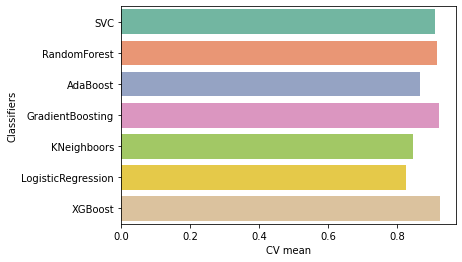

In [19]:
# building a K-fold cross validation
random_state = 55
clfs = [SVC(random_state=random_state), 
      RandomForestClassifier(random_state=random_state),
      AdaBoostClassifier(n_estimators=100, random_state=random_state, learning_rate=0.5),
      GradientBoostingClassifier(random_state=random_state),
      KNeighborsClassifier(),
      LogisticRegression(random_state=random_state),
      XGBClassifier(random_state=random_state)]

# running a 10-fold cross validation to get accuracy for each models
cv_means = []
cv_std = []
for clf in clfs:
    cv_results = cross_val_score(clf, X_train, Y_train, scoring="roc_auc", cv = 10)
    cv_means.append(cv_results.mean())
    cv_std.append(cv_results.std())
    
cv_res = pd.DataFrame({"CV mean":cv_means,"CV std": cv_std,"Classifiers":["SVC","RandomForest","AdaBoost",
"GradientBoosting","KNeighboors","LogisticRegression","XGBoost"]})

sns.set_palette("Set2")
graph = sns.barplot(x='CV mean', y='Classifiers', data= cv_res, orient='h')
print(cv_res)

'''
Choose RandomForest, GradientBoosting, KNeighboors, LogisticRegression, and XGBoost for 
hyperparameters tunning
'''

#### 3.3 Hyperparameter tunning with grid search

In [20]:
# print grid search results
def grid_search_output(gs):
    print('Best precision: %0.3f' % gs.best_score_)
    print('Best parameters set: \n', gs.best_params_)

##### Logistic Regression

In [21]:
# possible hyperparameter options for logistic regression:
# regularization: L1 or L2, regularization parameter lambda c
lr_parameters = {
    'penalty' : ('l1', 'l2'),
    'C' : (1, 5, 10, 15, 20)
}
grid_lr = GridSearchCV(LogisticRegression(), lr_parameters, cv = 10)
grid_lr.fit(X_train, Y_train)
# Best parameters option
grid_search_output(grid_lr)

Best precision: 0.863
Best parameters set: 
 {'C': 1, 'penalty': 'l2'}


##### KNN

In [22]:
# find the best k value
knn_parameter = {
    'n_neighbors' : [3,4,6, 7,9,12]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_parameter, cv=10)
grid_knn.fit(X_train, Y_train)
# best k
grid_search_output(grid_knn)

Best precision: 0.900
Best parameters set: 
 {'n_neighbors': 3}


##### Random Forest

In [23]:
# find the best number of trees
rf_parameter = {
    'n_estimators' : [20, 50 ,80]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_parameter, cv = 10)
rf_grid.fit(X_train, Y_train)
grid_search_output(rf_grid)

Best precision: 0.956
Best parameters set: 
 {'n_estimators': 50}


##### Gradient Boosting

In [24]:
# possible parameters for tunning
# loss, n_estimators, learning_rate, max_depth, min_samples_leaf, max_features
gb_parameters = {
    'loss' : ['deviance', 'exponential'],
    'n_estimators' : [100, 150],
    'learning_rate' : [0.1, 0.2, 0.01],
    'max_depth' : [3, 6],
    'min_samples_leaf' : [5, 10, 15],
    'max_features' : [0.2, 0.5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_parameters, cv = 10)
gb_grid.fit(X_train, Y_train)
grid_search_output(gb_grid)

Best precision: 0.961
Best parameters set: 
 {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 100}


##### XGBoost

In [25]:
# xgboost tunning
xgb_parameters = {
    'learning_rate' : [0.01, 0.1, 0.05],
    'max_depth' : [2, 4, 6],
    'subsample' : [0.25, 0.5]
}
xgb_grid = GridSearchCV(XGBClassifier(), xgb_parameters, cv = 5)
xgb_grid.fit(X_train, Y_train)
grid_search_output(xgb_grid)

Best precision: 0.958
Best parameters set: 
 {'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.5}


#### 3.4 Model Evaluation 
##### 3.4.1 Confusion Matrix (Precision, Recall, Accuracy

Identify churned customers as positive samples

True Positive: churned

Precision = tp / tp + fp

high precision = not many retained users were predicated as churn users

Recall(sensitivity) = tp / tp + fn 

high recall = out of all churned customers, many of them were correctly identified

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

# calculate recall, precision and accuracy
def cal_rpa(clf, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (clf)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print confusion matrix
def draw_confusion_matrix(confusion_matrix):
    class_values = ['Not churned', 'churned']
    for cm in confusion_matrix:
        clf, cm = cm[0], cm[1]
        cal_rpa(clf, cm)
        fig = plt.figure()
        ax = fig.add_subplot()
        color_ax = ax.matshow(cm, interpolation = 'nearest', cmap=plt.get_cmap('Greens'))
        plt.title('Predicated')
        fig.colorbar(color_ax)
        ax.set_xticklabels([''] + class_values)
        ax.set_yticklabels([''] + class_values)
        plt.xlabel('Confusion Mattrix for %s' % clf)
        plt.ylabel('Actual')
        plt.show()

RandomForest
Accuracy is: 0.955
precision is: 0.938
recall is: 0.734


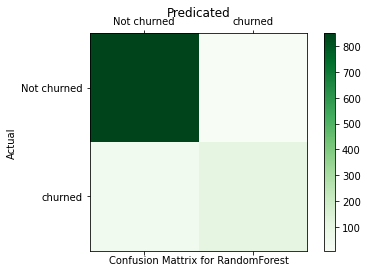

GradientBoosting
Accuracy is: 0.957
precision is: 0.939
recall is: 0.748


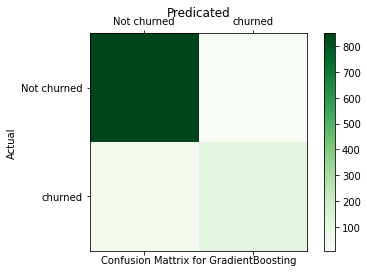

KNeighboors
Accuracy is: 0.884
precision is: 0.729
recall is: 0.301


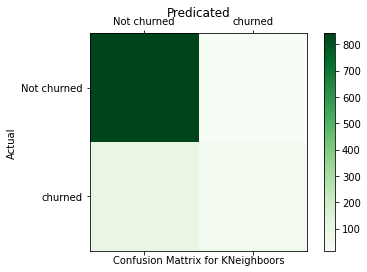

LogisticRegression
Accuracy is: 0.870
precision is: 0.644
recall is: 0.203


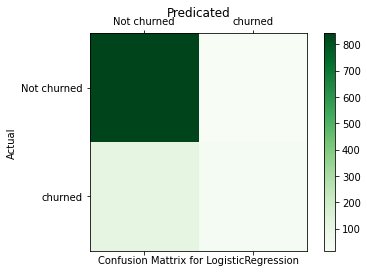

XGBoost
Accuracy is: 0.958
precision is: 0.963
recall is: 0.734


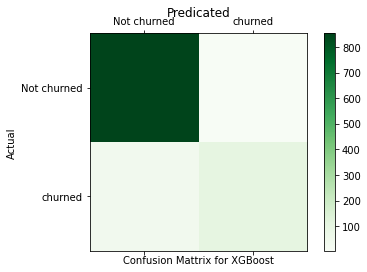

In [27]:
# confusion matrix for RandomForest, GradientBoosting, KNeighboors, LogisticRegression, and XGBoost
cms = [
    ('RandomForest', confusion_matrix(Y_test, rf_grid.best_estimator_.predict(X_test))),
    ('GradientBoosting', confusion_matrix(Y_test, gb_grid.best_estimator_.predict(X_test))),
    ('KNeighboors', confusion_matrix(Y_test, grid_knn.best_estimator_.predict(X_test))),
    ('LogisticRegression', confusion_matrix(Y_test, grid_lr.best_estimator_.predict(X_test))),
    ('XGBoost', confusion_matrix(Y_test, xgb_grid.best_estimator_.predict(X_test))),
]
# cms = [
#     ('RandomForest', confusion_matrix(Y_test, rf_grid.best_estimator_.predict(X_test))),
#     ('KNeighboors', confusion_matrix(Y_test, grid_knn.best_estimator_.predict(X_test))),
#     ('LogisticRegression', confusion_matrix(Y_test, grid_lr.best_estimator_.predict(X_test))),
#     ('XGBoost', confusion_matrix(Y_test, xgb_grid.best_estimator_.predict(X_test))),
# ]
draw_confusion_matrix(cms)

##### 3.4.2 ROC_AUC

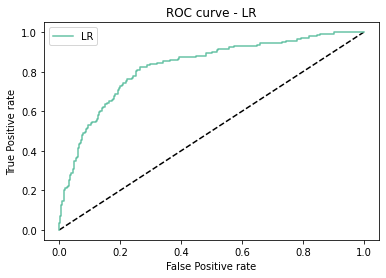

AUC score for LR is 0.8262845672413934


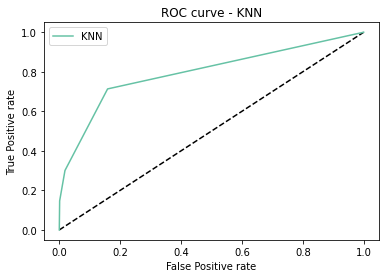

AUC score for KNN is 0.795693221597539


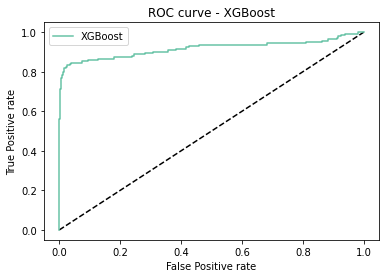

AUC score for XGBoost is 0.917528212744082


In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def draw_roc_auc(pred, clf):
    fpr, tpr, _ = roc_curve(Y_test, pred)
    plt.figure(1)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label = clf)
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
    plt.title('ROC curve - %s' % clf)
    plt.legend(loc='best')
    plt.show()
    print('AUC score for {} is {}'.format(clf, roc_auc_score(Y_test, pred)))

    
# pick XGBoost, KNN and LR for comparsion as they are the best/moderate/worst performer
y_pred_xgb = xgb_grid.best_estimator_.predict_proba(X_test)[:,1]
y_pred_lr = grid_lr.best_estimator_.predict_proba(X_test)[:,1]
y_pred_knn = grid_knn.best_estimator_.predict_proba(X_test)[:,1]

draw_roc_auc(y_pred_lr, 'LR')
draw_roc_auc(y_pred_knn, 'KNN')
draw_roc_auc(y_pred_xgb, 'XGBoost')


### Part 4. Feature Selection
#### Part 4.1 Feature selection for Logistic Regression
'''
By examining the correlation graph, features which are highly correlated 
are (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge) and (total_intl_minutes, total_intl_charge)
'''

In [29]:
# use L1(LASSO) regularizaiton on LR and check for coefficient
scaler = StandardScaler()
lr_l1_x = scaler.fit_transform(X)
lr_l1 = LogisticRegression(solver = 'saga', penalty='l1', C = 0.05)
lr_l1.fit(lr_l1_x, Y)
print(lr_l1.coef_[0])

print('LR coefficients with L1 regularization: ')
for k, v in sorted(zip(data_train.columns,  
                       map(lambda x : round(x, 4), lr_l1.coef_[0])),
                  key=lambda kv : (-abs(kv[1]), kv[0])):
    print(k + ": " + str(v))

[ 0.01568818  0.57140723 -0.40522927  0.          0.34954893  0.01046044
  0.31982883  0.14573546  0.          0.15284706  0.08721141  0.
  0.06441896  0.08658136 -0.12382309  0.10475627  0.61807958]
LR coefficients with L1 regularization: 
number_customer_service_calls: 0.6181
intl_plan: 0.5714
voice_mail_plan: -0.4052
total_day_minutes: 0.3495
total_day_charge: 0.3198
total_eve_charge: 0.1528
total_eve_minutes: 0.1457
total_intl_calls: -0.1238
total_intl_charge: 0.1048
total_night_minutes: 0.0872
total_intl_minutes: 0.0866
total_night_charge: 0.0644
account_length: 0.0157
total_day_calls: 0.0105
number_vmail_messages: 0.0
total_eve_calls: 0.0
total_night_calls: 0.0


In [30]:
# use L2(ridge) regularization on LR and check for coefficient

lr_l2_x = scaler.fit_transform(X)
lr_l2 = LogisticRegression(penalty='l2', C = 0.05)
lr_l2.fit(lr_l2_x, Y)
print(lr_l2.coef_[0])

print('LR coefficients with L2 regularization: ')
for k, v in sorted(zip(data_train.columns,  
                       map(lambda x : round(x, 4), lr_l2.coef_[0])),
                  key=lambda kv : (-abs(kv[1]), kv[0])):
    print(k + ": " + str(v))

[ 0.05385442  0.59306133 -0.49450361  0.05195019  0.35609257  0.04879417
  0.35572945  0.17269978 -0.02871012  0.17281055  0.09729187 -0.03095169
  0.09697765  0.117511   -0.16624232  0.11774349  0.64532563]
LR coefficients with L2 regularization: 
number_customer_service_calls: 0.6453
intl_plan: 0.5931
voice_mail_plan: -0.4945
total_day_minutes: 0.3561
total_day_charge: 0.3557
total_eve_charge: 0.1728
total_eve_minutes: 0.1727
total_intl_calls: -0.1662
total_intl_charge: 0.1177
total_intl_minutes: 0.1175
total_night_minutes: 0.0973
total_night_charge: 0.097
account_length: 0.0539
number_vmail_messages: 0.052
total_day_calls: 0.0488
total_night_calls: -0.031
total_eve_calls: -0.0287


#### 4.2 Random forest model - feature importance discussion

In [31]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, Y)
importances = forest.feature_importances_
# print the feature ranking
for k, v in sorted(zip(map(lambda x : round(x, 4), importances),
                      X.columns), reverse = True):
    print(v + ": " + str(k))

total_day_charge: 0.1493
total_day_minutes: 0.1397
number_customer_service_calls: 0.1166
intl_plan: 0.0916
total_eve_charge: 0.0661
total_eve_minutes: 0.0654
total_intl_calls: 0.0557
total_night_minutes: 0.0421
total_night_charge: 0.0395
total_intl_charge: 0.039
total_intl_minutes: 0.0374
account_length: 0.0294
number_vmail_messages: 0.0278
total_day_calls: 0.0276
total_night_calls: 0.0263
total_eve_calls: 0.0244
voice_mail_plan: 0.022


We can conclude that 'total_day_minutes' and 'total_day_charge' play a relatively important in making the classification decision

### Conclusion

After comparing different models, we can see that boosting and tree based model tend to perform well. For gradient boosting, the number of estimators can aggressively affect the classification performances, the more estimators we set, the better the precision. However, there is a good chance that gradient boosting might overfit the training data. This happened when gradient boosting underperformed on testing data compared with XGboost.

The factors that contribute the most on customer retention are 'total_day_charge', 'number_customer_service_calls' and 'total_day_minutes'. This is not unexpected and we can easily imply that
customers who spend more money on calls would expect a better service and reliable network connection ,however, if the service isn't as good as they expected, they are more likely to complain and the number of customer service calls would definitely go up. 